In [1]:
import pandas as pd
import networkx as nx

## Preparing the data

We first load the files that interest us in DataFrames:
- The file `routes` contains route information, and especially the description of the route (i.e. is it for trams, busses, metro, train, etc)
- The file `trips` contains trip information, and especially the route each trip uses
- The file `stop_times` contains all stop information for each trip, especially the stop id
- The file `stop` contains all geographical information for each stop

In [2]:
DATA_PATH = 'data/gtfs_fp2021_2021-03-31_09-10/'

In [3]:
routes = pd.read_csv('{}routes.txt'.format(DATA_PATH), delimiter=',')
routes.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type
0,91-10-A-j21-1,37,10,NaN,Tram,900
1,91-10-B-j21-1,06____,S10,NaN,S-Bahn,109
2,91-10-C-j21-1,11,RE10,NaN,RegioExpress,106
3,91-10-D-j21-1,11,S10,NaN,S-Bahn,109
4,91-10-F-j21-1,78,S10,NaN,S-Bahn,109


In [4]:
trips = pd.read_csv('{}trips.txt'.format(DATA_PATH), delimiter=',')
trips.head()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id
0,91-10-A-j21-1,TA+ej,1.TA.91-10-A-j21-1.1.H,"Ettingen, Bahnhof",10100,0
1,91-10-A-j21-1,TA+d9,10.TA.91-10-A-j21-1.2.H,"Flüh, Bahnhof",10006,0
2,91-10-A-j21-1,TA+g1,100.TA.91-10-A-j21-1.8.H,"Flüh, Bahnhof",10188,0
3,91-10-A-j21-1,TA,101.TA.91-10-A-j21-1.8.H,"Flüh, Bahnhof",10506,0
4,91-10-A-j21-1,TA+g1,102.TA.91-10-A-j21-1.8.H,"Flüh, Bahnhof",10386,0


In [5]:
stop_times = pd.read_csv('{}stop_times.txt'.format(DATA_PATH), delimiter=',')
stop_times.head()

/home/karim/anaconda3/envs/cds/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type
0,120.TA.91-4-H-j21-1.9.R,13:58:00,13:58:00,8503088:0:21,1,0,0
1,120.TA.91-4-H-j21-1.9.R,13:59:00,13:59:00,8503090,2,0,0
2,120.TA.91-4-H-j21-1.9.R,14:01:00,14:01:00,8503091,3,0,0
3,120.TA.91-4-H-j21-1.9.R,14:03:00,14:03:00,8503087,4,0,0
4,120.TA.91-4-H-j21-1.9.R,14:04:00,14:04:00,8503086,5,0,0


In [6]:
stops = pd.read_csv('{}stops.txt'.format(DATA_PATH), delimiter=',')
stops.head()

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station
0,1100006,"Zell (Wiesental), Bahnhof",47.704632,7.847772,NaN,NaN
1,1100008,"Zell (Wiesental), Wilder Mann",47.710084,7.859648,NaN,NaN
2,1100009,"Zell (Wiesental), Grönland",47.713191,7.862909,NaN,NaN
3,1100010,Atzenbach,47.714618,7.872350,NaN,NaN
4,1100011,"Mambach, Brücke",47.728209,7.877470,NaN,NaN


Now that the data is loaded, we're interested in keeping the stops that correspond to modes of transport that interest us, that is, railway transportation. In order to achieve this:
- We filter out the routes that do not interest us
- Subsequently, we filter our the trips using routes that do not interest us
- We remove stops of trips that do not interest us

In [7]:
modes_to_remove = ['Tram', 'Bus', 'Schiff', 'Metro', 'Taxi', 
                   'Rufbus', 'Nachtbus', 'PanoramaBus', 'Fernbus national']
modes_of_interest = [mode for mode in routes.route_desc.unique() if mode not in modes_to_remove]

In [8]:
routes_filtered = routes[routes.route_desc.isin(modes_of_interest)]
routes_filtered.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type
1,91-10-B-j21-1,06____,S10,NaN,S-Bahn,109
2,91-10-C-j21-1,11,RE10,NaN,RegioExpress,106
3,91-10-D-j21-1,11,S10,NaN,S-Bahn,109
4,91-10-F-j21-1,78,S10,NaN,S-Bahn,109
6,91-10-Y-j21-1,23,R,NaN,Regio,106


In [9]:
trips_filtered = trips[trips.route_id.isin(routes_filtered.route_id.unique())]
stop_times_filtered = stop_times[stop_times.trip_id.isin(trips_filtered.trip_id.unique())]

railway_stops = stops[stops.stop_id.isin(stop_times_filtered.stop_id.unique())].copy()

In [10]:
print('Initially, there are {} stops when considering all modes of transport.'.format(len(stops)))
print('By considering only railway transport, we are left with {} stops.'.format(len(railway_stops)))

Initially, there are 36448 stops when considering all modes of transport.
By considering only railway transport, we are left with 5909 stops.


In [11]:
railway_stops[railway_stops.stop_name.str.contains('Lausanne')]

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station
5799,8501120,Lausanne,46.516793,6.629091,NaN,8501120P
5800,8501120:0:1,Lausanne,46.516793,6.629091,NaN,8501120P
5801,8501120:0:3,Lausanne,46.516793,6.629091,NaN,8501120P
5802,8501120:0:4,Lausanne,46.516793,6.629091,NaN,8501120P
5803,8501120:0:5,Lausanne,46.516793,6.629091,NaN,8501120P
5804,8501120:0:6,Lausanne,46.516793,6.629091,NaN,8501120P
5805,8501120:0:6A-D,Lausanne,46.516793,6.629091,NaN,8501120P
5806,8501120:0:6E-G,Lausanne,46.516793,6.629091,NaN,8501120P
5807,8501120:0:7,Lausanne,46.516793,6.629091,NaN,8501120P
5808,8501120:0:70,Lausanne,46.516793,6.629091,NaN,8501120P


Notice that some large main stations have multiple stop identifiers: all of these ids share a same prefix. We therefore edit all ids to just include the prefix and then drop duplicates.

In [12]:
railway_stops['stop_id'] = railway_stops['stop_id'].apply(lambda id_: id_.split(':')[0])
railway_stops.drop_duplicates(subset=['stop_id'], inplace=True)

In [13]:
railway_stops[railway_stops.stop_name.str.contains('Lausanne')]

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station
5799,8501120,Lausanne,46.516793,6.629091,NaN,8501120P
5854,8501160,Lausanne-Chauderon,46.523228,6.626063,NaN,NaN
5860,8501166,Romanel-sur-Lausanne,46.562469,6.603165,NaN,NaN
5873,8501181,Lausanne-Flon,46.520799,6.630339,NaN,NaN


In [14]:
import plotly.express as px

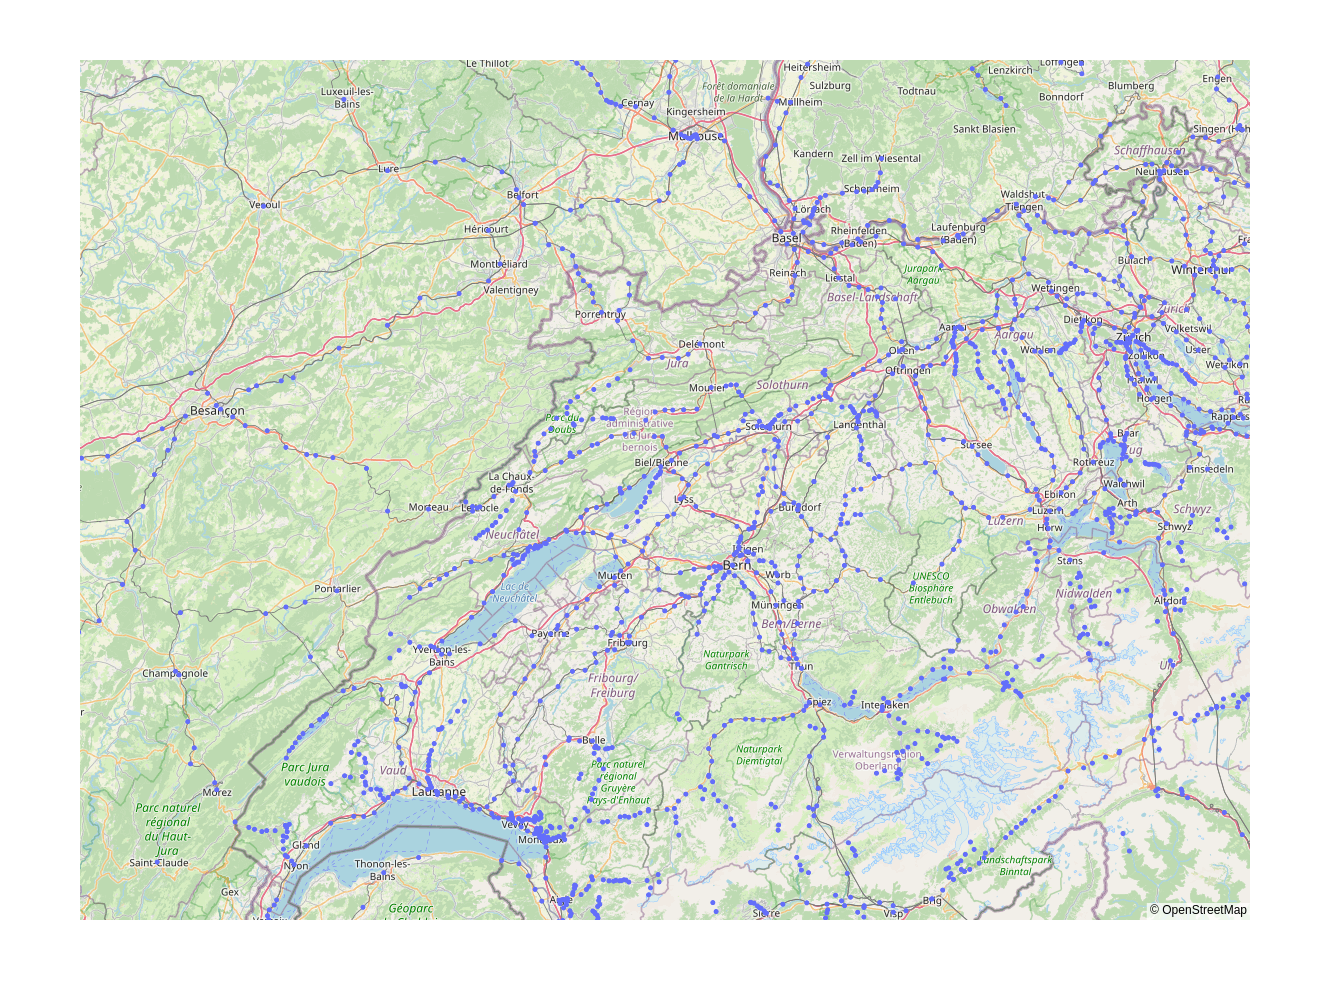

In [20]:
fig = px.scatter_mapbox(data_frame=railway_stops, lat = 'stop_lat', lon = 'stop_lon')
fig.update_layout(mapbox_style="open-street-map", height = 1000)

fig.show()